In [2]:
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from tqdm import tqdm
import os
os.chdir('..')

# QMIX

[Original paper (compact)](https://arxiv.org/pdf/1803.11485.pdf)

[Original paper (extended)](https://arxiv.org/pdf/2003.08839.pdf)

[Original implementation](https://github.com/oxwhirl/pymarl)

- **Only suitable in cooperative environments**
- Value-based multi-agent deep RL algorithm, with DQN foundation
  - Learns value ($Q$) function using experiences sampled from a replay memory
  - Stabilizes target values with target network/parameters
- Each agent $a$ has its own action-value function $Q_a(\tau^a, u^a)$
  - $Q_a$ is represented as a *deep recurrent Q-network* (DRQN), with the use of a gated recurrent unit (GRU)
  - Individual agents can benefit from using their entire action-observation history ($\tau^a$) in partially observable settings
  - $u^a$ is the action to take in the current state
- QMIX performs centralized training by learning a joint action-value function $Q_\text{tot}(\boldsymbol{\tau},\textbf{u})$ where $\boldsymbol{\tau}$ is a joint action-observation history and $\textbf{u}$ is a joint action
  - $Q_\text{tot}$ is composed of $Q_a$ all agents $a$ in a way such that: $$\underset{\textbf{u}}{\mathrm{argmax}}\;Q_\text{tot}(\boldsymbol{\tau},\textbf{u}) = \left\{\underset{\textbf{u}^a}{\mathrm{argmax}}\;Q_a(\tau^a,\text{u}^a)\;|\; \forall a\in A\right\}$$ allowing for decentralized execution
  - The above condition holds as long as $Q_\text{tot}$ is monotonic (increasing) with respect to each $Q_a$: $$\frac{\partial Q_\text{tot}}{\partial Q_a}\ge 0$$

## Network Architecture
- In practice, $Q_\text{tot}$ is the output of a *mixing network* that combines the outputs of each *agent network*, $Q_a$
  - The weights and biases of the mixing network are produced by hypernetworks that take in total state information and also train off of replay memory
  - To ensure monotonicty, the weights produced are set as non-negative via absolute value activation

[Network implementation details here](https://arxiv.org/pdf/2003.08839.pdf#page=13)

![qmix network](<qmix network.png>)

## Algorithm

- $\tau^a$ - individual agent's observation history
- $u^a$ - action chosen by individual agent
- $\textbf{u}$ - joint action (actions of all agents)

![qmix](qmix.png)

- Parameter Sharing: https://arxiv.org/pdf/2005.13625.pdf

# Demos

In [9]:
import pickle
from scripts.qmix import MultiAgentDRQN, DRQN

In [4]:
def get_saved_results(filename):
    res = {}
    with open(f"testfiles/{filename}.results", 'rb') as file:
        res = pickle.load(file)
    return res

In [5]:
def show_returns(results):
    episode_returns = results['episode_returns']
    episode_returns = results['episode_returns'][list(episode_returns.keys())[0]]
    plt.plot(range(len(episode_returns)), episode_returns)
    plt.title('Total return')
    plt.show()
    plt.plot(range(len(episode_returns)), [np.mean(episode_returns[max(0,x-100):x+1]) for x in range(len(episode_returns))])
    plt.title('Moving average of total return (k=100)')
    plt.xlim(left=100)
    plt.show()

In [6]:
def right_pad(length: int, *inputs: torch.Tensor, dim: int = 0, value=0):
    '''
    Right-pads the input tensors to the specified length in the given dimension and return
    '''
    inputs = tuple(input.transpose(0, dim) for input in inputs) #swap with outermost dimension
    #pad outermost dimension, then swap dims back
    outs = tuple(F.pad(input, 2*tuple(0 for _ in range(input.ndim-1)) + (0, length-input.shape[0]), value=value).transpose(0, dim) for input in inputs)
    return outs if len(outs) > 1 else outs[0]

In [7]:
from gymnasium.utils.save_video import save_video
from pettingzoo import AECEnv, ParallelEnv
def run_record_model(model, env: AECEnv | ParallelEnv, num_episodes=1, video_prefix: str = 'qmix',seeds: list[int] | None = None):
    #NOTE: env must have render_mode='rgb_array'
    frames = []
    obs_history = {agent: [] for agent in env.possible_agents}
    act_history = {agent: [] for agent in env.possible_agents}
    for _ in range(num_episodes):
        seed = random.choice(seeds) if seeds else None
        if issubclass(type(env), AECEnv):
            env.reset(seed=seed)
            agent_t = {agent: 0 for agent in env.possible_agents}
            for agent in env.agent_iter():
                obs, reward, terminated, truncated, _ = env.last()
                frames.append(env.render())

                obs = right_pad(model.obs_dim, torch.tensor(obs))
                obs_history[agent].append(obs)
                act_history[agent].append(torch.zeros(1, dtype=torch.long))
                curr_obs_hist = torch.stack(obs_history[agent])
                curr_act_hist = torch.stack(act_history[agent])
                
                if terminated or truncated:
                    env.step(None)
                else:
                    action = model.select_action(curr_obs_hist, agent, curr_act_hist)
                    env.step(action.item())
                    act_history[agent][-1] = action.cpu()
                
                agent_t[agent] += 1
        else:
            state = env.reset(seed=seed)[0]
            for _ in count():
                frames.append(env.render())
                if not env.agents: break
                actions = {} #agent: action dict to pass to env.step function
                for agent in env.agents:
                    #store agent obs at time t
                    obs = right_pad(model.obs_dim, torch.tensor(state[agent]))
                    obs_history[agent].append(obs)
                    act_history[agent].append(torch.zeros(1, dtype=torch.long))
                    curr_obs_hist = torch.stack(obs_history[agent])
                    curr_act_hist = torch.stack(act_history[agent])
                    
                    action = model.select_action(curr_obs_hist, agent, curr_act_hist)
                    act_history[agent][-1] = action.cpu()
                    
                    actions[agent] = action.item()
                state, reward, _, _, _ = env.step(actions)
    save_video(frames, "recordings/qmix", fps=30, name_prefix=video_prefix)
    env.close()

## Simple

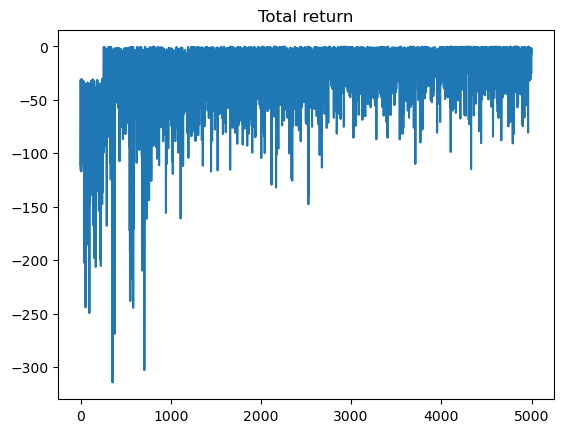

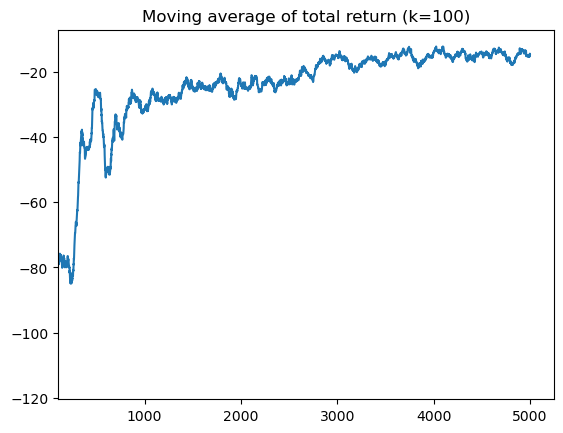

t:  70%|███████   | 183/260 [2:00:51<00:00, 471.93it/s, now=None]

Moviepy - Building video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_simple-episode-0.mp4.
Moviepy - Writing video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_simple-episode-0.mp4



t:  70%|███████   | 183/260 [2:00:53<00:00, 471.93it/s, now=None]

Moviepy - Done !
Moviepy - video ready c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_simple-episode-0.mp4


In [52]:
returns = get_saved_results('qmix_simple')
show_returns(returns)
from pettingzoo.mpe import simple_v3
env = simple_v3.env(render_mode='rgb_array')
run_record_model(returns['final_model'], env, num_episodes=10, video_prefix='qmix_simple', seeds=returns['seeds'])

## Speaker Listener

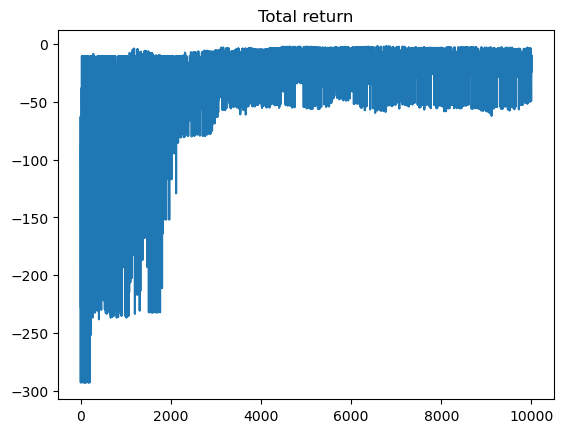

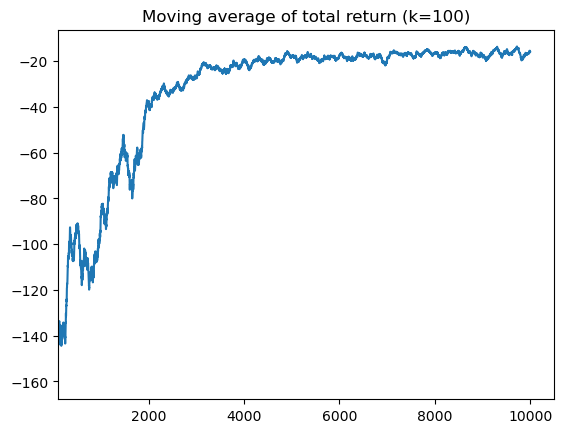

Moviepy - Building video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_speakerlistener-episode-0.mp4.
Moviepy - Writing video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_speakerlistener-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_speakerlistener-episode-0.mp4


In [13]:
returns = get_saved_results('qmix_speakerlistener_lastaction_seeded')
show_returns(returns)
from pettingzoo.mpe import simple_speaker_listener_v4
env = simple_speaker_listener_v4.env(render_mode='rgb_array')
run_record_model(returns['best_model'], env, num_episodes=10, video_prefix='qmix_speakerlistener', seeds=returns['seeds'])

## Spread

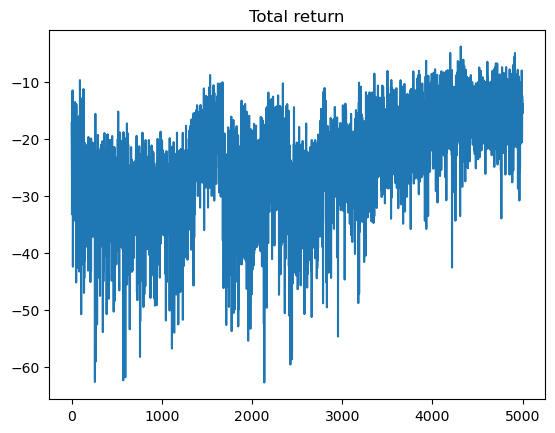

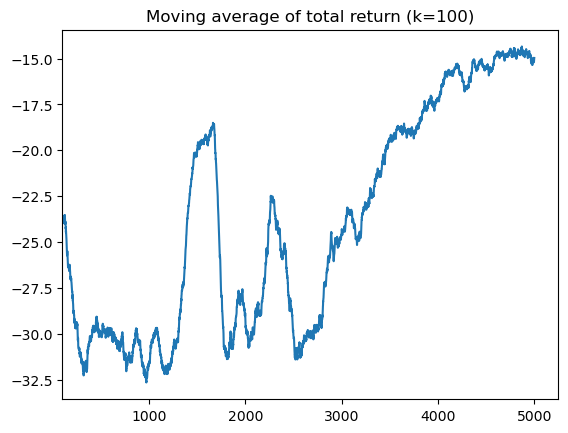

t:  70%|███████   | 183/260 [01:02<00:00, 471.93it/s, now=None]

Moviepy - Building video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_spread-episode-0.mp4.
Moviepy - Writing video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_spread-episode-0.mp4



t:  70%|███████   | 183/260 [01:03<00:00, 471.93it/s, now=None]

Moviepy - Done !
Moviepy - video ready c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_spread-episode-0.mp4


In [50]:
returns = get_saved_results('qmix_spread_lastaction')
show_returns(returns)
from pettingzoo.mpe import simple_spread_v3
env = simple_spread_v3.env(render_mode='rgb_array')
run_record_model(returns['final_model'], env, num_episodes=10, video_prefix='qmix_spread')

## Reference

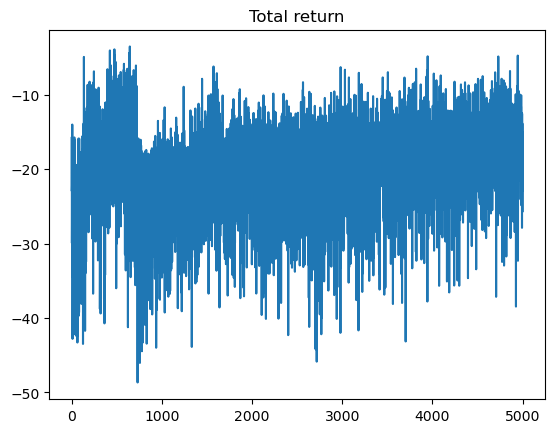

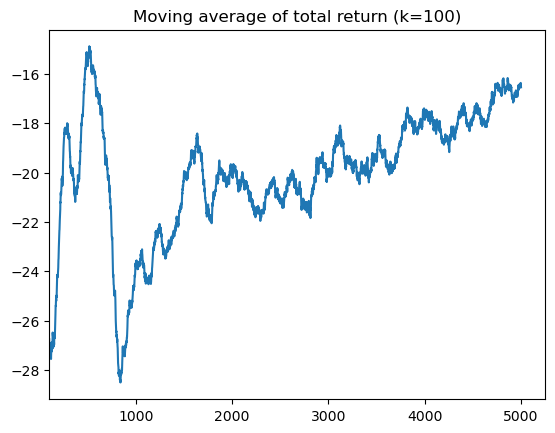

t:  70%|███████   | 183/260 [01:22<00:00, 471.93it/s, now=None]

Moviepy - Building video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_reference-episode-0.mp4.
Moviepy - Writing video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_reference-episode-0.mp4



t:  70%|███████   | 183/260 [01:23<00:00, 471.93it/s, now=None]

Moviepy - Done !
Moviepy - video ready c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\qmix/qmix_reference-episode-0.mp4


In [51]:
returns = get_saved_results('qmix_reference_lastaction')
show_returns(returns)
from pettingzoo.mpe import simple_reference_v3
env = simple_reference_v3.env(render_mode='rgb_array')
run_record_model(returns['final_model'], env, num_episodes=10, video_prefix='qmix_reference')